<a href="https://colab.research.google.com/github/nguyenanhtienabcd/AIO2024_EXERCISE/blob/feature%2FMODULE7-WEEK2/m07w02_ex2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification + Bounding Box Regession

In [1]:
pip install kagglehub

In [2]:
import kagglehub
data_dir = kagglehub.dataset_download("andrewmvd/dog-and-cat-detection")
print('Path to dataset files:', data_dir)

100%|██████████| 1.03G/1.03G [00:21<00:00, 50.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/andrewmvd/dog-and-cat-detection/versions/1


In [3]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import torch.optim as optim
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from torchvision.models.resnet import ResNet18_Weights

In [4]:
from genericpath import isfile
# định nghĩa một lớp class image mới
class ImageDataset(Dataset):

  #------ khởi tạo dữ liệu---------
  def __init__(self, annotations_dir, image_dir, transform = None):
    self.annotations_dir = annotations_dir
    self.image_dir = image_dir
    self.transform = transform
    self.image_files = self.filter_image_with_multiple_objects()

  #------ lọc dữ liệu---------
  def filter_image_with_multiple_objects(self):
    # tạo một list chứa các file thỏa mãn
    valid_image_files = []
    for f in os.listdir(self.image_dir):
      if os.path.isfile(os.path.join(self.image_dir, f)):
        img_name = f
        # mục đích của đoạn code này là chia file thành 2 phần
        # [file name, extention] => [0] là lấy file name
        annotation_name = img_name.split('.')[0] + '.xml'
        annotation_path = os.path.join(self.annotations_dir, annotation_name)

        # tạo một hàm dữ lại các ảnh có object đơn
        if self.count_objects_in_annotation(annotation_path) ==1:
          valid_image_files.append(img_name)
        else:
          print(f'Image {img_name} has multiple objects and will be excluded the dataset')
    return valid_image_files

   #------ đếm đối tượng---------
  def count_objects_in_annotation(self, annotation_path):
    try:
      tree = ET.parse(annotation_path) # đọc file xml từ path
      root = tree.getroot() # lấy phần gốc của file xml
      count = 0
      for obj in root.findall('object'):
        count += 1
      return count
    except Exception as e:
      print(f'Error reading annotation file {annotation_path}: {e}')
      return 0

  def __len__(self):
    return len(self.image_files)

  #------ lấy mẫu---------
  def __getitem__(self, idx):
    # đường dẫn ảnh
    img_name = self.image_files[idx]
    img_path = os.path.join(self.image_dir, img_name)

    # load ảnh lên
    image = Image.open(img_path).convert('RGB')

    # annotation path
    annotation_name = img_name.split('.')[0] + '.xml'
    annotation_path = os.path.join(self.annotations_dir, annotation_name)

    # Parse annotation
    label, bbox = self.parse_annotation(annotation_path)
    if self.transform:
      image = self.transform(image)
    return image, label, bbox

    #------ phân tích annotations---------
  def parse_annotation(self, annotation_path): # un-indent this method
      tree = ET.parse(annotation_path)
      root = tree.getroot()

      # lấy kích thước của ảnh để chuẩn hóa
      image_width = int(root.find('size').find('width').text)
      image_height = int(root.find('size').find('height').text)

      label = None
      bbox = None

      for obj in root.findall('object'):
        name = obj.find('name').text
        if (label is None):
          # lấy label đầu tiên
          label = name

          # lấy thông tin về bounding box
          xmin = int(obj.find('bndbox/xmin').text)
          ymin = int(obj.find('bndbox/ymin').text)
          xmax = int(obj.find('bndbox/xmin').text)
          ymax = int(obj.find('bndbox/ymin').text)

          # chuẩn hóa bounding box trong khoảng từ [0,1]
          bbox = [xmin/image_width,
                  ymin/image_height,
                  xmax/image_width,
                  ymax/image_height]

        label_num = 0 if label == 'cat' else 1 if label == 'dog' else -1
        return label_num, torch.tensor(bbox, dtype=torch.float32)

In [5]:
annotations_dir = os.path.join(data_dir, 'annotations')
image_dir = os.path.join(data_dir, 'images')

image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
df = pd.DataFrame({'image_name': image_files})



In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=42)

In [7]:
# transform và chuyển dữ liệu sang tensor
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset
#train_dataset, val_dataset, test_dataset có cùng một tệp dữ liệu
train_dataset = ImageDataset(annotations_dir, image_dir, transform)
val_dataset = ImageDataset(annotations_dir, image_dir, transform)
test_dataset = ImageDataset(annotations_dir, image_dir, transform)

# lọc dataset
# lọc tất cả các file nào nằm trong dataframe train, val, test
train_dataset.image_files =  [f for f in train_dataset.image_files if f in train_df['image_name'].values]
val_dataset.image_files =  [f for f in val_dataset.image_files if f in val_df['image_name'].values]
test_dataset.image_files =  [f for f in test_dataset.image_files if f in test_df['image_name'].values]


Image Cats_Test736.png has multiple objects and will be excluded the dataset
Image Cats_Test736.png has multiple objects and will be excluded the dataset
Image Cats_Test736.png has multiple objects and will be excluded the dataset


In [8]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
class TwoHeadeModel(nn.Module):
  def __init__(self, num_classes = 2):
    super(TwoHeadeModel, self).__init__()
    self.base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    # lất layer cuối cùng ra
    self.num_ftrs = self.base_model.fc.in_features
    # thay đổi layer cuối cùng
    self.base_model.fc = nn.Identity()

    # xóa toàn bộ trọng số của layer cuối cùng, sau đó tuning lại
    self.classifier = nn.Linear(self.num_ftrs, num_classes)

    # bounding box head (x_min, y_min, x_max, y_max)
    self.bbox_regressor = nn.Linear(self.num_ftrs, 4)

  def forward(self, x):
    base_out = self.base_model(x)
    class_out = self.classifier(base_out)
    # tại vì ban đầu mình đã normalize trong khoảng (0,1)
    bbox_out = torch.sigmoid(self.bbox_regressor(base_out))

    return class_out, bbox_out

Cài đặt cho model

In [10]:
model = TwoHeadeModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion_class = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 186MB/s]


In [11]:
# trainning loop
num_epochs = 10
for epoch in range(num_epochs):
  model.train()
  for batch_idx, (images, labels, bboxes) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
    bboxes = bboxes.to(device)
    optimizer.zero_grad()

    class_outputs, bbox_outputs = model(images)
    loss_class = criterion_class(class_outputs, labels)
    loss_bbox = criterion_bbox(bbox_outputs, bboxes)
    loss = loss_class + loss_bbox # loss combination
    loss.backward()
    optimizer.step()

  model.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    total_sample = 0
    total_loss_bbox = 0
    total_loss_class = 0
    for images, labels, bboxes in val_loader:
      images = images.to(device)
      labels = labels.to(device)
      bboxes = bboxes.to(device)

      class_outputs, bbox_outputs = model(images)
      _, predicted = torch.max(class_outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      # tính toán bounding box cho việc giám sát
      loss_bbox = criterion_bbox(bbox_outputs, bboxes)
      total_loss_bbox += loss_bbox.item() * images.size(0)
      total_sample += images.size(0)

    avg_loss_bbox = total_loss_bbox / total_sample
    print (f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy : {float(correct)/ float(total) *100:.2f}%,'
            f'Avg. Bbox Loss : { avg_loss_bbox :.4f}')




Epoch 1/10, Validation Accuracy : 90.79%,Avg. Bbox Loss : 0.0157
Epoch 2/10, Validation Accuracy : 66.94%,Avg. Bbox Loss : 0.0111
Epoch 3/10, Validation Accuracy : 92.41%,Avg. Bbox Loss : 0.0096
Epoch 4/10, Validation Accuracy : 90.79%,Avg. Bbox Loss : 0.0107
Epoch 5/10, Validation Accuracy : 88.08%,Avg. Bbox Loss : 0.0070
Epoch 6/10, Validation Accuracy : 95.93%,Avg. Bbox Loss : 0.0065
Epoch 7/10, Validation Accuracy : 93.77%,Avg. Bbox Loss : 0.0071
Epoch 8/10, Validation Accuracy : 82.38%,Avg. Bbox Loss : 0.0080
Epoch 9/10, Validation Accuracy : 94.04%,Avg. Bbox Loss : 0.0066
Epoch 10/10, Validation Accuracy : 94.04%,Avg. Bbox Loss : 0.0069


Test Accuracy: 94.30%, Avg. Bbox Loss: 0.0063


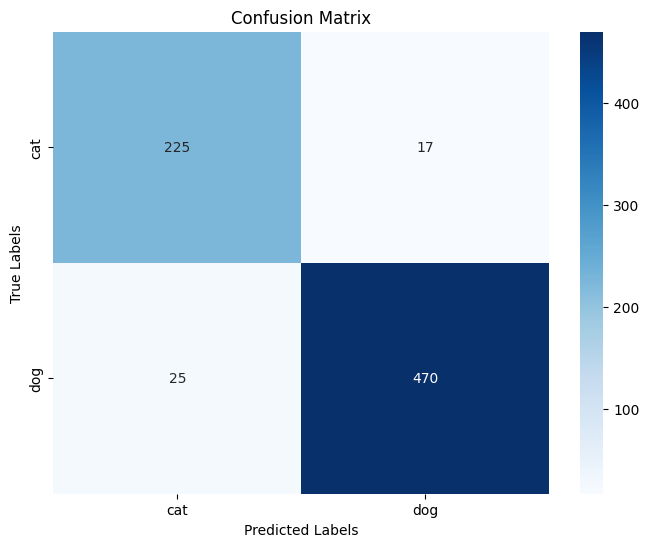

In [12]:
# prompt: kiểm tra dữ liệu với tệp test

# Assuming 'test_dataset' and 'test_loader' are defined as in the provided code.

# Evaluation on the test set
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    total_sample = 0
    total_loss_bbox = 0
    total_loss_class = 0
    all_predictions = []
    all_labels = []
    for images, labels, bboxes in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        bboxes = bboxes.to(device)

        class_outputs, bbox_outputs = model(images)
        _, predicted = torch.max(class_outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Calculate bounding box loss for monitoring
        loss_bbox = criterion_bbox(bbox_outputs, bboxes)
        total_loss_bbox += loss_bbox.item() * images.size(0)
        total_sample += images.size(0)

    avg_loss_bbox = total_loss_bbox / total_sample
    accuracy = float(correct) / float(total) * 100
    print(f'Test Accuracy: {accuracy:.2f}%, Avg. Bbox Loss: {avg_loss_bbox:.4f}')

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['cat', 'dog'], yticklabels=['cat', 'dog'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Assuming you have a test_loader and model as defined in your previous code

model.eval()
with torch.no_grad():
    for images, labels, bboxes in test_loader:
        images = images.to(device)
        labels, bboxes = labels.to(device), bboxes.to(device)
        class_outputs, bbox_outputs = model(images)
        _, predicted = torch.max(class_outputs, 1)

        for i in range(images.shape[0]):  # Iterate through each image in the batch
            image = images[i].permute(1, 2, 0).cpu().numpy()  # Convert image tensor to numpy array
            image = (image * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]) #denormalize
            image = np.clip(image,0,1) # clip image to valid range

            true_label = labels[i].item()
            predicted_label = predicted[i].item()

            true_bbox = bboxes[i].cpu().numpy()
            predicted_bbox = bbox_outputs[i].cpu().numpy()


            fig, ax = plt.subplots(1)
            ax.imshow(image)

            # True bounding box
            true_width = true_bbox[2] - true_bbox[0]
            true_height = true_bbox[3] - true_bbox[1]
            true_rect = patches.Rectangle((true_bbox[0]*224, true_bbox[1]*224), true_width *224, true_height*224, linewidth=2, edgecolor='g', facecolor='none')

            # Predicted bounding box
            predicted_width = predicted_bbox[2] - predicted_bbox[0]
            predicted_height = predicted_bbox[3] - predicted_bbox[1]
            predicted_rect = patches.Rectangle((predicted_bbox[0]*224, predicted_bbox[1]*224), predicted_width*224, predicted_height*224, linewidth=2, edgecolor='r', facecolor='none')

            ax.add_patch(true_rect)
            ax.add_patch(predicted_rect)

            ax.set_title(f'True: {true_label}, Predicted: {predicted_label}')
            plt.show()

            #break  # remove this line to visualize all images in a batch
        #break # remove this line to visualize all batches

